In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import numpy as np

import scipy.io
import scipy.signal 

from matplotlib import mlab
import matplotlib.pyplot as plt


In [3]:
def psd(trials):
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs


def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

def bandpass(trials, lo, hi, sample_rate):
 
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

def logvar(trials):
    return np.var(trials, axis=1)

def plot_logvar(trials, trial_no = None):
    plt.figure(figsize=(12,5))

    print(trials[cl1].shape)
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    if trial_no == None:
        y0 = np.mean(trials[cl1], axis=1)
        y1 = np.mean(trials[cl2], axis=1)
    else:
        y0 = trials[cl1][:,trial_no]
        y1 = trials[cl2][:,trial_no]

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

from numpy import linalg

def cov(trials):
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

import torch
import snntorch.spikeplot as splt
from snntorch import spikegen

def spike_latency(trials, trial_n, cls, num_steps):
    input_data = trials[cl1] if cls == 1 else trials[cl2]
    
    tensor = torch.tensor(input_data[:,trial_n])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    
    spike_data = spikegen.latency(tensor, num_steps=num_steps, threshold=(np.mean(input_data[:,trial_n])+1)*1/2, bypass=True)

    return spike_data

def spike_rate(trials, trial_n, cls, num_steps):
    input_data = trials[cl1] if cls == 1 else trials[cl2]
    
    tensor = torch.tensor(input_data[:,trial_n])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    
    spike_data = spikegen.rate(tensor, num_steps=num_steps)

    return spike_data

def plot_raster(spike_data):
    
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    spike_data_sample = spike_data
    splt.raster(spike_data_sample, ax, s=1.5, c="black")
    plt.ylim(0, 60)
    
    plt.title("Input Layer")
    plt.xlabel("Time step")
    plt.ylabel("Neuron Number")
    plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])


  plt.show()

def plot_snn_spikes_modified(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=False, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes

  neuron_numbers = list(range(59))
  currents = spk_in.tolist()  # Currents fed to each neuron
    
  # Create bar chart
  ax[0].bar(neuron_numbers, currents, color='skyblue')
  ax[0].set_ylabel("Input Currents")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])


  plt.show()

In [4]:
m = scipy.io.loadmat('BCICIV_1_mat\BCICIV_calib_ds1d.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [5]:
trials = {}

win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    cl_onsets = event_onsets[event_codes == code]

    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

In [6]:
trials_filt = {cl1: bandpass(trials[cl1], 2, 30, sample_rate),
               cl2: bandpass(trials[cl2], 2, 30, sample_rate)}

In [7]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

In [8]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}

In [9]:
normalized_within_trial = {cl1: ((trials_logvar[cl1]-np.min(trials_logvar[cl1],axis=0))/(np.max(trials_logvar[cl1],axis=0)-np.min(trials_logvar[cl1],axis=0))),
                 cl2: ((trials_logvar[cl2]-np.min(trials_logvar[cl2],axis=0))/(np.max(trials_logvar[cl2],axis=0)-np.min(trials_logvar[cl2],axis=0)))}

In [10]:
max_value = np.max(trials_logvar[cl1]) or np.max(trials_logvar[cl2])
min_value = np.min(trials_logvar[cl1]) or np.min(trials_logvar[cl2])


normalized_trials_logvar = {cl1: ((trials_logvar[cl1]-min_value)/(max_value-min_value)),
                 cl2: ((trials_logvar[cl2]-min_value)/(max_value-min_value))}

In [11]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        if len(self.data.shape) > 1:
            return self.data.shape[1]
        else:
            return 1

    def __getitem__(self, idx):
        sample = self.data[1:,idx]
        label = self.data[0,idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [13]:
data = normalized_within_trial

# Additional column for class identifiers
class_column_left = np.zeros((1, 100))  # Assuming all instances belong to class 0
class_column_right = np.ones((1, 100))  # Assuming all instances belong to class 0

# Concatenate class column along with left and right arrays
left_with_class = np.concatenate([class_column_left, data['left']], axis=0)
right_with_class = np.concatenate([class_column_right, data['right']], axis=0)

# Concatenate left and right arrays along axis 1
result = np.concatenate([left_with_class, right_with_class], axis=1)

cl1_split_idx = int(result.shape[1]*0.5*0.8)
cl2_split_idx = int(result.shape[1]*0.5*1.8)

train_data = np.concatenate([result[:, :cl1_split_idx],result[:, 100:cl2_split_idx]], axis=1)
test_data = np.concatenate([result[:, cl1_split_idx:100],result[:, cl2_split_idx:]], axis=1)

# Create CustomDataset instance
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#for samples, labels in train_loader:
    # Your training code here
    #print(samples.shape, labels.shape)

In [14]:
num_inputs = 59
num_hidden = 1000
num_outputs = 2
beta = 0.99

In [15]:
# Define Network
class Net(nn.Module):
    def __init__(self, num_steps):
        super().__init__()

        self.num_steps = num_steps

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        self.spkIn = []
        self.spk1 = []
        self.spk2 = []

    def _rate_coding(self, x):
        tensor = torch.tensor(x)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tensor = tensor.to(device)
    
        spike_data = spikegen.rate(tensor, num_steps=self.num_steps)

        return spike_data

    def test(self,x):
        print(x.shape)
        print(self._rate_coding(x).shape)
        
        
    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        self.spkIn = []
        self.spk1 = []
        self.spk2 = []
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        spk_in = self._rate_coding(x)

        for step in range(self.num_steps):
            cur1 = self.fc1(spk_in[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            self.spkIn.append(spk_in[step])
            self.spk1.append(spk1)
            self.spk2.append(spk2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        


In [40]:
def accuracy(data, targets):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    return acc*100

In [41]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [82]:
num_steps = 1000
net = Net(num_steps).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [83]:
num_epochs = 20

loss_hist = []
test_loss_hist = []

train_acc_hist = []
test_acc_hist = []

counter = 0


# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Store Accuracy for future plotting
        train_acc_val = accuracy(data,targets)
        train_acc_hist.append(train_acc_val)

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Store Accuracy for future plotting
            test_acc_val = accuracy(data,targets)
            test_acc_hist.append(test_acc_val)

            # Print train/test loss/accuracy
            if counter % 4 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

C:\Users\USER\AppData\Local\Temp\ipykernel_20532\1880285545.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_20532\227537944.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


Epoch 0, Iteration 0
Train Set Loss: 2177.18
Test Set Loss: 1559.59
Train set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 53.12%


Epoch 0, Iteration 4
Train Set Loss: 541.80
Test Set Loss: 465.91
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 81.25%


Epoch 1, Iteration 3
Train Set Loss: 212.34
Test Set Loss: 210.48
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 84.38%


Epoch 2, Iteration 2
Train Set Loss: 559.85
Test Set Loss: 313.52
Train set accuracy for a single minibatch: 81.25%
Test set accuracy for a single minibatch: 87.50%


Epoch 3, Iteration 1
Train Set Loss: 32.18
Test Set Loss: 40.11
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 100.00%


Epoch 4, Iteration 0
Train Set Loss: 84.27
Test Set Loss: 29.06
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 100.00

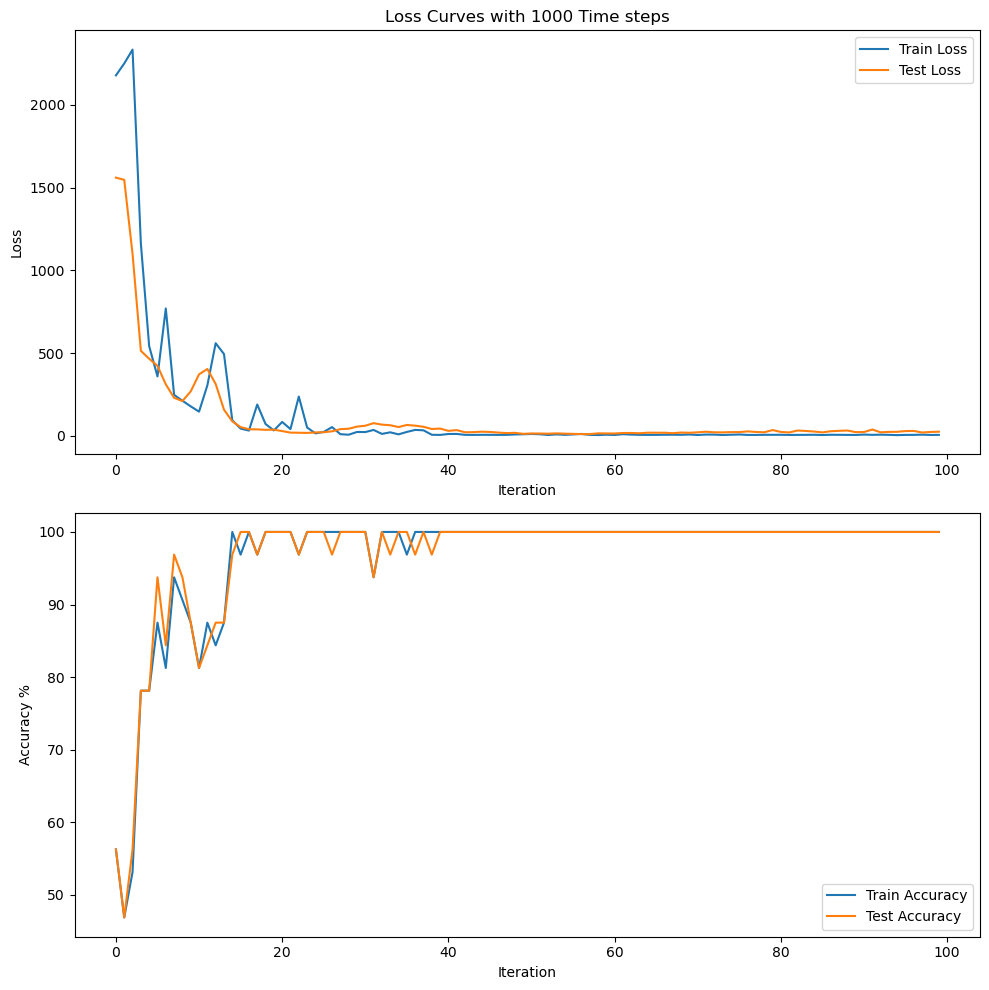

In [85]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), facecolor='w') # Creates 2 subplots

loss_hist1000 = loss_hist
test_loss_hist1000 = test_loss_hist
train_acc_hist1000 = train_acc_hist
test_acc_hist1000 = test_acc_hist

# Plot for loss
axs[0].plot(loss_hist, label="Train Loss")
axs[0].plot(test_loss_hist, label="Test Loss")
axs[0].set_title("Loss Curves with 1000 Time steps")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot for accuracy
axs[1].plot(train_acc_hist, label="Train Accuracy")
axs[1].plot(test_acc_hist, label="Test Accuracy")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Accuracy %")
axs[1].legend()

plt.tight_layout()

plt.savefig("rate_coding_1000_time_steps.png", dpi=300)

plt.show()

torch.save(net.state_dict(), 'Rate_Coding_model_1000_time_steps.pth')

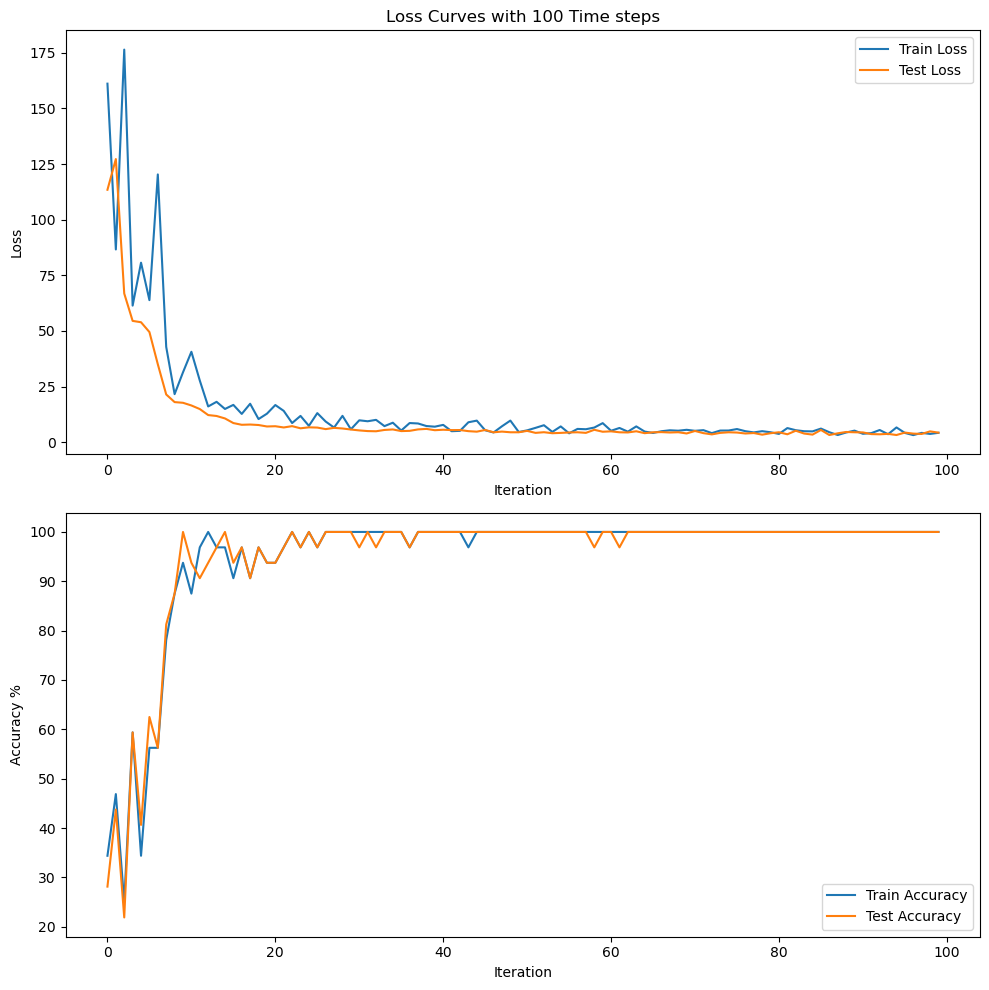

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), facecolor='w') # Creates 2 subplots

loss_hist100 = loss_hist
test_loss_hist100 = test_loss_hist
train_acc_hist100 = train_acc_hist
test_acc_hist100 = test_acc_hist


# Plot for loss
axs[0].plot(loss_hist, label="Train Loss")
axs[0].plot(test_loss_hist, label="Test Loss")
axs[0].set_title("Loss Curves with 100 Time steps")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot for accuracy
axs[1].plot(train_acc_hist, label="Train Accuracy")
axs[1].plot(test_acc_hist, label="Test Accuracy")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Accuracy %")
axs[1].legend()

plt.tight_layout()

plt.savefig("rate_coding_100_time_steps.png", dpi=300)

plt.show()

torch.save(net.state_dict(), 'Rate_Coding_model_100_time_steps.pth')

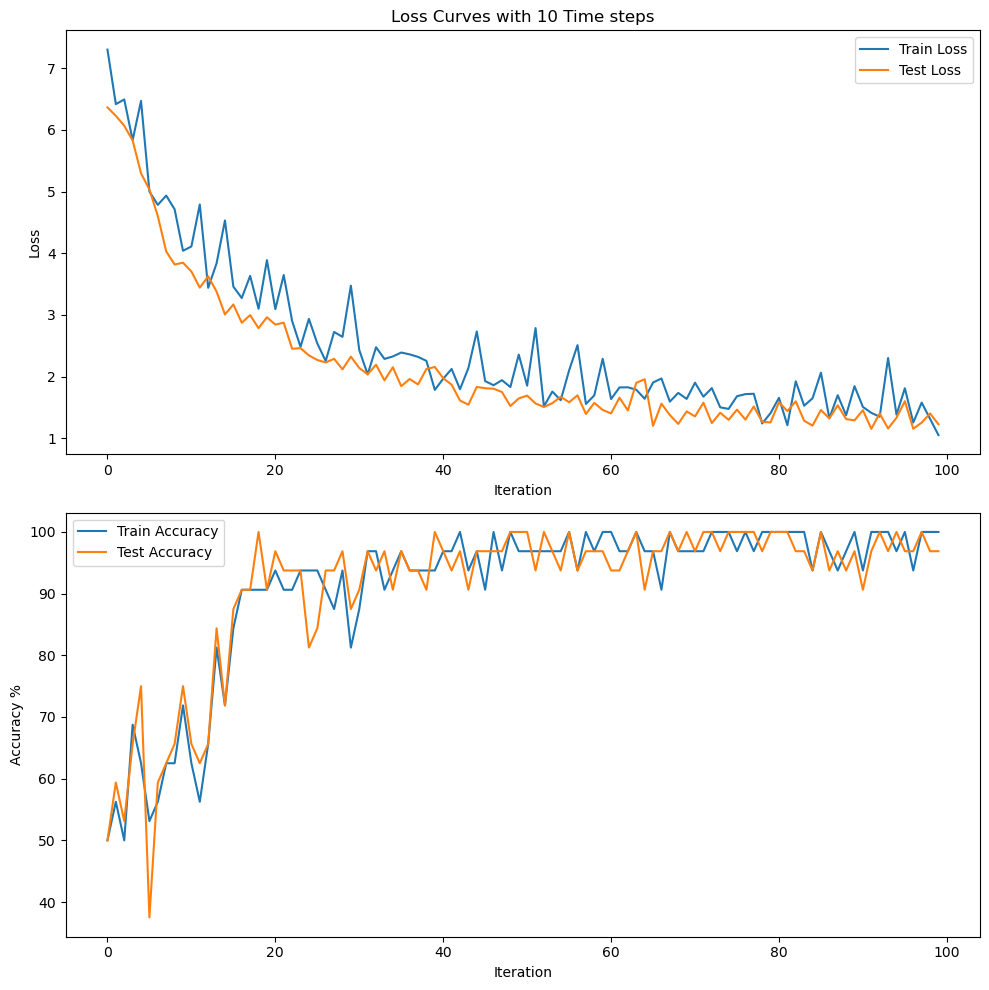

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), facecolor='w') # Creates 2 subplots

loss_hist10 = loss_hist
test_loss_hist10 = test_loss_hist
train_acc_hist10 = train_acc_hist
test_acc_hist10 = test_acc_hist

# Plot for loss
axs[0].plot(loss_hist, label="Train Loss")
axs[0].plot(test_loss_hist, label="Test Loss")
axs[0].set_title("Loss Curves with 10 Time steps")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot for accuracy
axs[1].plot(train_acc_hist, label="Train Accuracy")
axs[1].plot(test_acc_hist, label="Test Accuracy")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Accuracy %")
axs[1].legend()

plt.tight_layout()

plt.savefig("rate_coding_10_time_steps.png", dpi=300)

plt.show()

torch.save(net.state_dict(), 'Rate_Coding_model_10_time_steps.pth')

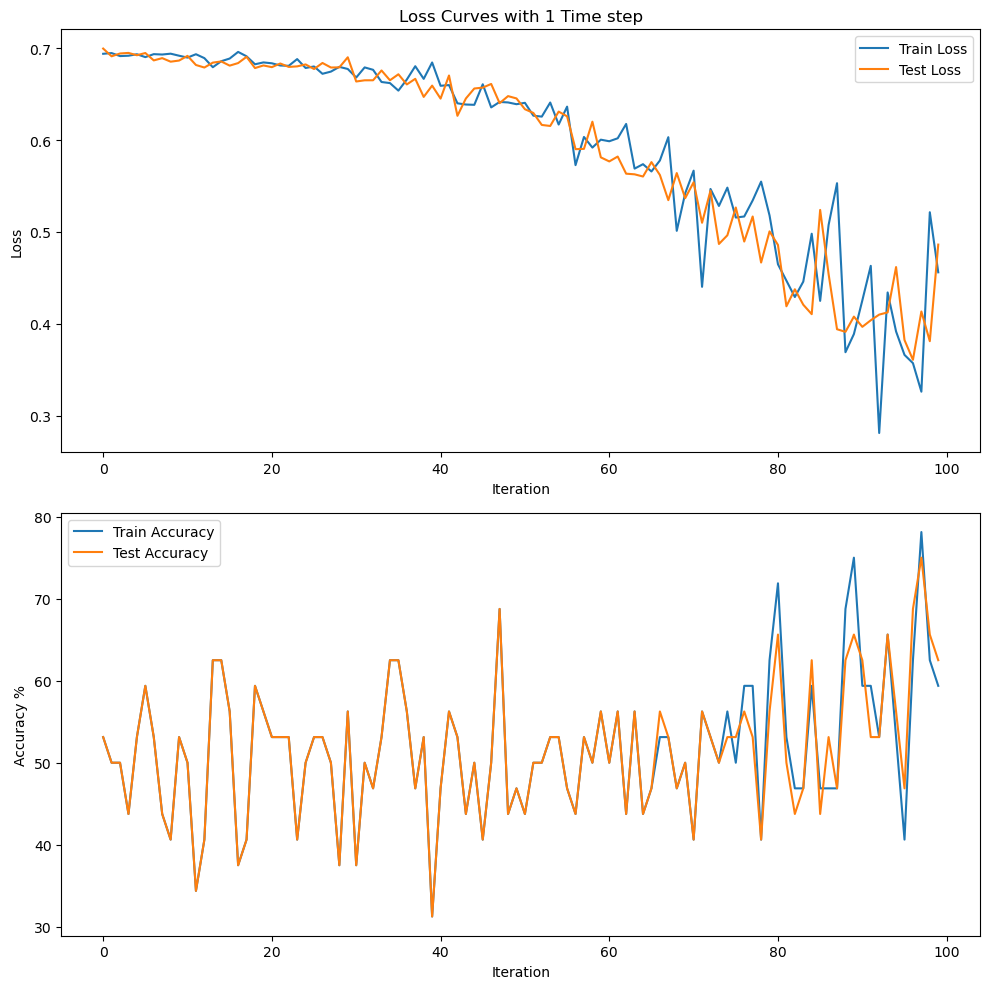

In [69]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), facecolor='w') # Creates 2 subplots

loss_hist1 = loss_hist
test_loss_hist1 = test_loss_hist
train_acc_hist1 = train_acc_hist
test_acc_hist1 = test_acc_hist

# Plot for loss
axs[0].plot(loss_hist, label="Train Loss")
axs[0].plot(test_loss_hist, label="Test Loss")
axs[0].set_title("Loss Curves with 1 Time step")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot for accuracy
axs[1].plot(train_acc_hist, label="Train Accuracy")
axs[1].plot(test_acc_hist, label="Test Accuracy")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Accuracy %")
axs[1].legend()

plt.tight_layout()

plt.savefig("rate_coding_1_time_step.png", dpi=300)

plt.show()

torch.save(net.state_dict(), 'Rate_Coding_model_1_time_step.pth')

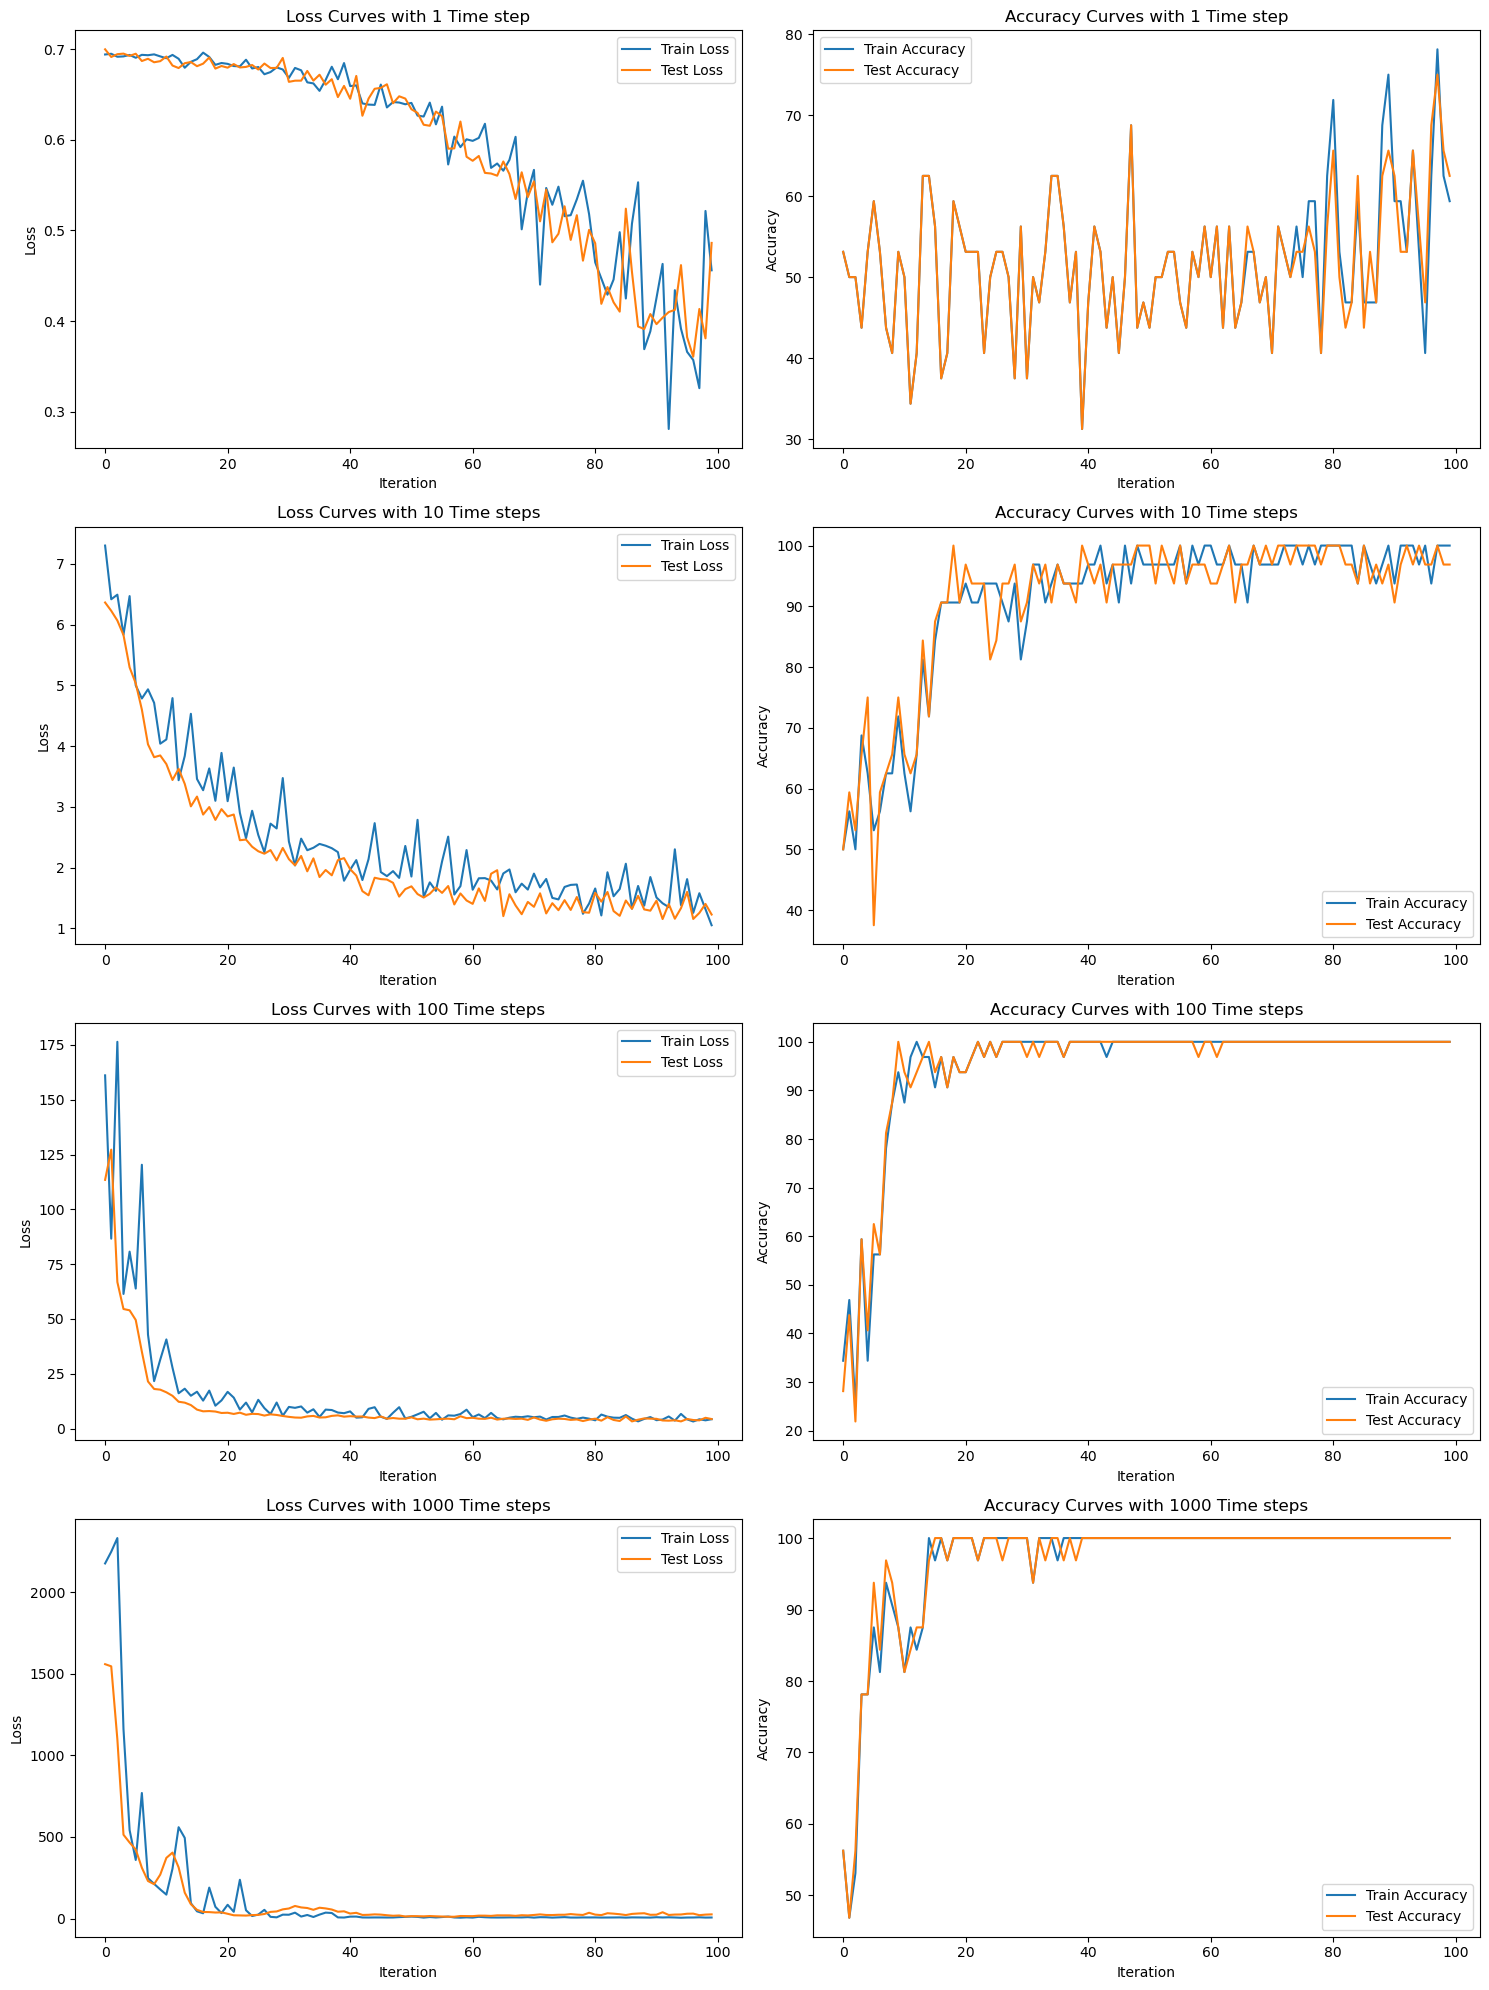

In [86]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20), facecolor='w') # 4x2 subplots

# Data for 1 time step
axs[0, 0].plot(loss_hist1, label="Train Loss")
axs[0, 0].plot(test_loss_hist1, label="Test Loss")
axs[0, 0].set_title("Loss Curves with 1 Time step")
axs[0, 0].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

axs[0, 1].plot(train_acc_hist1, label="Train Accuracy")
axs[0, 1].plot(test_acc_hist1, label="Test Accuracy")
axs[0, 1].set_title("Accuracy Curves with 1 Time step")
axs[0, 1].set_xlabel("Iteration")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].legend()

# Data for 10 time steps
axs[1, 0].plot(loss_hist10, label="Train Loss")
axs[1, 0].plot(test_loss_hist10, label="Test Loss")
axs[1, 0].set_title("Loss Curves with 10 Time steps")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()

axs[1, 1].plot(train_acc_hist10, label="Train Accuracy")
axs[1, 1].plot(test_acc_hist10, label="Test Accuracy")
axs[1, 1].set_title("Accuracy Curves with 10 Time steps")
axs[1, 1].set_xlabel("Iteration")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()

# Data for 100 time steps
axs[2, 0].plot(loss_hist100, label="Train Loss")
axs[2, 0].plot(test_loss_hist100, label="Test Loss")
axs[2, 0].set_title("Loss Curves with 100 Time steps")
axs[2, 0].set_xlabel("Iteration")
axs[2, 0].set_ylabel("Loss")
axs[2, 0].legend()

axs[2, 1].plot(train_acc_hist100, label="Train Accuracy")
axs[2, 1].plot(test_acc_hist100, label="Test Accuracy")
axs[2, 1].set_title("Accuracy Curves with 100 Time steps")
axs[2, 1].set_xlabel("Iteration")
axs[2, 1].set_ylabel("Accuracy")
axs[2, 1].legend()

# Data for 1000 time steps
axs[3, 0].plot(loss_hist1000, label="Train Loss")
axs[3, 0].plot(test_loss_hist1000, label="Test Loss")
axs[3, 0].set_title("Loss Curves with 1000 Time steps")
axs[3, 0].set_xlabel("Iteration")
axs[3, 0].set_ylabel("Loss")
axs[3, 0].legend()

axs[3, 1].plot(train_acc_hist1000, label="Train Accuracy")
axs[3, 1].plot(test_acc_hist1000, label="Test Accuracy")
axs[3, 1].set_title("Accuracy Curves with 1000 Time steps")
axs[3, 1].set_xlabel("Iteration")
axs[3, 1].set_ylabel("Accuracy")
axs[3, 1].legend()

plt.tight_layout()

# Save the plot
plt.savefig("Rating_code_training_performance_detailed.png", dpi=300)

plt.show()

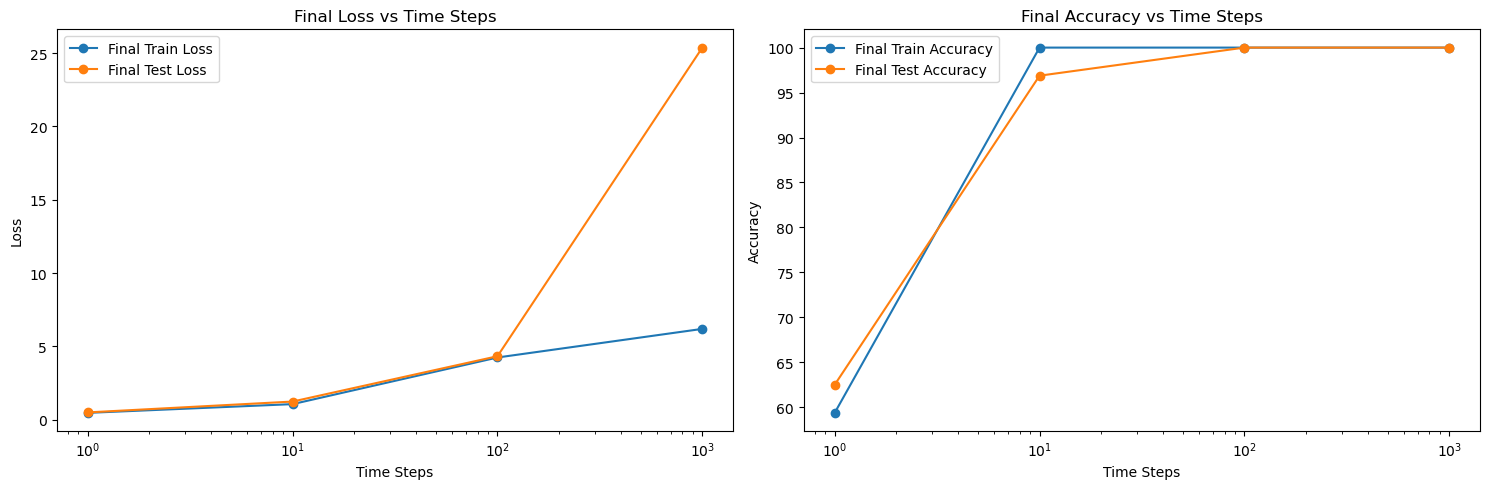

In [87]:
# Extract the last elements of each list
final_train_loss = [loss_hist1[-1], loss_hist10[-1], loss_hist100[-1], loss_hist1000[-1]]
final_test_loss = [test_loss_hist1[-1], test_loss_hist10[-1], test_loss_hist100[-1], test_loss_hist1000[-1]]
final_train_acc = [train_acc_hist1[-1], train_acc_hist10[-1], train_acc_hist100[-1], train_acc_hist1000[-1]]
final_test_acc = [test_acc_hist1[-1], test_acc_hist10[-1], test_acc_hist100[-1], test_acc_hist1000[-1]]

time_steps = [1, 10, 100, 1000]

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), facecolor='w') # 1x2 subplots

# Plot for loss
axs[0].plot(time_steps, final_train_loss, label="Final Train Loss", marker='o')
axs[0].plot(time_steps, final_test_loss, label="Final Test Loss", marker='o')
axs[0].set_title("Final Loss vs Time Steps")
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Loss")
axs[0].set_xscale('log') # Use logarithmic scale for x-axis to better visualize the time steps
axs[0].legend()

# Plot for accuracy
axs[1].plot(time_steps, final_train_acc, label="Final Train Accuracy", marker='o')
axs[1].plot(time_steps, final_test_acc, label="Final Test Accuracy", marker='o')
axs[1].set_title("Final Accuracy vs Time Steps")
axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Accuracy")
axs[1].set_xscale('log') # Use logarithmic scale for x-axis to better visualize the time steps
axs[1].legend()

plt.tight_layout()

# Save the plot
plt.savefig("final_performance_vs_timesteps.png", dpi=300)

plt.show()

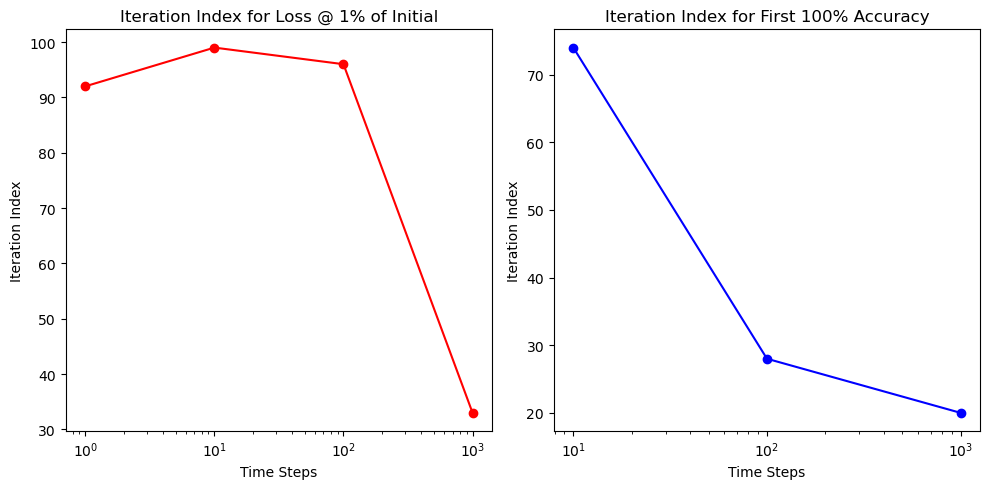

In [96]:
def closest_to_percentage(hist, percentage):
    """
    Find the index of the value in hist that is closest to the percentage of the initial value.
    """
    initial_value = hist[0]
    target_value = initial_value * percentage
    closest_index = None
    closest_diff = float('inf')
    for i, value in enumerate(hist):
        diff = abs(value - target_value)
        if diff < closest_diff:
            closest_diff = diff
            closest_index = i
    return closest_index

def first_reach_99_percent_moving_average(hist, window_size=3, target=100):
    """
    Find the index of the first value in the moving average of hist
    that reaches or exceeds the target percentage.
    """
    # Calculate moving average with the specified window size
    moving_averages = []
    for i in range(len(hist)):
        if i + 1 < window_size:
            # Not enough data points to calculate moving average
            continue
        window = hist[i - window_size + 1:i + 1]
        moving_avg = sum(window) / window_size
        moving_averages.append(moving_avg)
    
    # Find the first moving average that exceeds the target
    for i, avg in enumerate(moving_averages):
        if avg >= target:
            return i + window_size - 1  # Adjust index to match original list
    return None

# Assuming your data lists are already defined

# Lists of histories for iteration
loss_histories = [loss_hist1, loss_hist10, loss_hist100, loss_hist1000]
acc_histories = [train_acc_hist1, train_acc_hist10, train_acc_hist100, train_acc_hist1000]

# Calculate indices
loss_indices = [closest_to_percentage(hist, 0.01) for hist in loss_histories]
accuracy_indices_99ma = [first_reach_99_percent_moving_average(hist) for hist in acc_histories]

# Time steps for plotting
time_steps = [1, 10, 100, 1000]

plt.figure(figsize=(10, 5))

# Plot for the iteration index where loss is closest to 1% of its initial value
plt.subplot(1, 2, 1)
plt.plot(time_steps, loss_indices, marker='o', linestyle='-', color='red')
plt.title("Iteration Index for Loss @ 1% of Initial")
plt.xlabel("Time Steps")
plt.ylabel("Iteration Index")
plt.xscale("log")

# Plot for the iteration index where accuracy first reaches/exceeds 100%
plt.subplot(1, 2, 2)
plt.plot(time_steps, accuracy_indices_99ma, marker='o', linestyle='-', color='blue')
plt.title("Iteration Index for First 100% Accuracy")
plt.xlabel("Time Steps")
plt.ylabel("Iteration Index")
plt.xscale("log")

plt.tight_layout()
plt.savefig("performance_criteria_vs_time_steps.png", dpi=300)
plt.show()

In [93]:
loss_indices

[None, None, 12, 8]